In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/"

Question 1

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale = (0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
# valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)


# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [ ]:
os.listdir(train_directory)

['watermelon', 'tomato', 'durian', 'pumpkin']

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data_size, test_data_size

(521, 323)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
model_ft = models.resnet18(weights=True)  #if False, the weight will randomly initialized
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9560, Accuracy: 59.3090%, 
		Validation : Loss : 1.4302, Accuracy: 45.8204%, Time: 72.3853s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.7006, Accuracy: 72.5528%, 
		Validation : Loss : 1.0649, Accuracy: 79.5666%, Time: 6.8191s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5950, Accuracy: 79.4626%, 
		Validation : Loss : 0.9632, Accuracy: 80.8050%, Time: 6.8061s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.5670, Accuracy: 80.9981%, 
		Validation : Loss : 0.9557, Accuracy: 82.9721%, Time: 6.7814s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.5518, Accuracy: 80.8061%, 
		Validation : Loss : 0.9632, Accuracy: 81.4241%, Time: 6.7935s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.5089, Accuracy: 82.9175%, 
		Validation : Loss : 0.8921, Accuracy: 82.9721%, Time: 6.6942s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.5024, Accuracy: 80.8061%, 
		Validation : Loss : 0.8809, Accuracy: 82.9721%, Time: 6.8217s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.5210, Accuracy: 80

Question 2

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                            [0.5, 0.5, 0.5])
       ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
input_size = (3,32,32)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(weights=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.bn1(self.relu(self.fc0(output)))
       # output = self.bn2(self.relu(self.fc1(output)))
        output = self.classifier(output)
                
        return output
    
model_ft = model_ft.to(device)
    
model_ft = MyCustomResnet18()

criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.1744, Accuracy: 49.5202%, 
		Validation : Loss : 0.9925, Accuracy: 63.4675%, Time: 7.8345s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.8243, Accuracy: 71.7850%, 
		Validation : Loss : 1.0488, Accuracy: 64.7059%, Time: 6.9358s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.6688, Accuracy: 78.5029%, 
		Validation : Loss : 0.8796, Accuracy: 70.8978%, Time: 6.9772s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.7114, Accuracy: 77.3512%, 
		Validation : Loss : 0.8237, Accuracy: 69.9690%, Time: 6.8240s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.6564, Accuracy: 76.3916%, 
		Validation : Loss : 0.8455, Accuracy: 73.6842%, Time: 6.8566s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.6073, Accuracy: 80.6142%, 
		Validation : Loss : 0.8145, Accuracy: 73.0650%, Time: 6.9371s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.6015, Accuracy: 80.2303%, 
		Validation : Loss : 0.7670, Accuracy: 75.8514%, Time: 6.9466s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.5349, Accuracy: 83.

Question 3

In [ ]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/improved fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

269
323


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
input_size = (3,32,32)

In [ ]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(weights=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.bn1(self.relu(self.fc0(output)))
       # output = self.bn2(self.relu(self.fc1(output)))
        output = self.classifier(output)
                
        return output
    
model_ft = model_ft.to(device)
    
model_ft = MyCustomResnet18()

criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.2348, Accuracy: 51.6729%, 
		Validation : Loss : 1.1523, Accuracy: 63.4675%, Time: 334.6302s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6659, Accuracy: 75.4647%, 
		Validation : Loss : 0.9150, Accuracy: 71.5170%, Time: 4.5175s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5456, Accuracy: 81.7844%, 
		Validation : Loss : 0.8093, Accuracy: 73.9938%, Time: 4.4674s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4575, Accuracy: 83.2714%, 
		Validation : Loss : 0.8030, Accuracy: 70.5882%, Time: 4.4314s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4117, Accuracy: 87.7323%, 
		Validation : Loss : 0.6600, Accuracy: 79.2570%, Time: 4.4392s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.4513, Accuracy: 82.5279%, 
		Validation : Loss : 0.5815, Accuracy: 81.4241%, Time: 4.4658s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3461, Accuracy: 87.7323%, 
		Validation : Loss : 0.4927, Accuracy: 82.3529%, Time: 4.4547s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3067, Accuracy: 8

watermelon 0.9919288158416748
durian 0.0034375833347439766
tomatoes 0.003069319762289524
pumpkin 0.001564268721267581


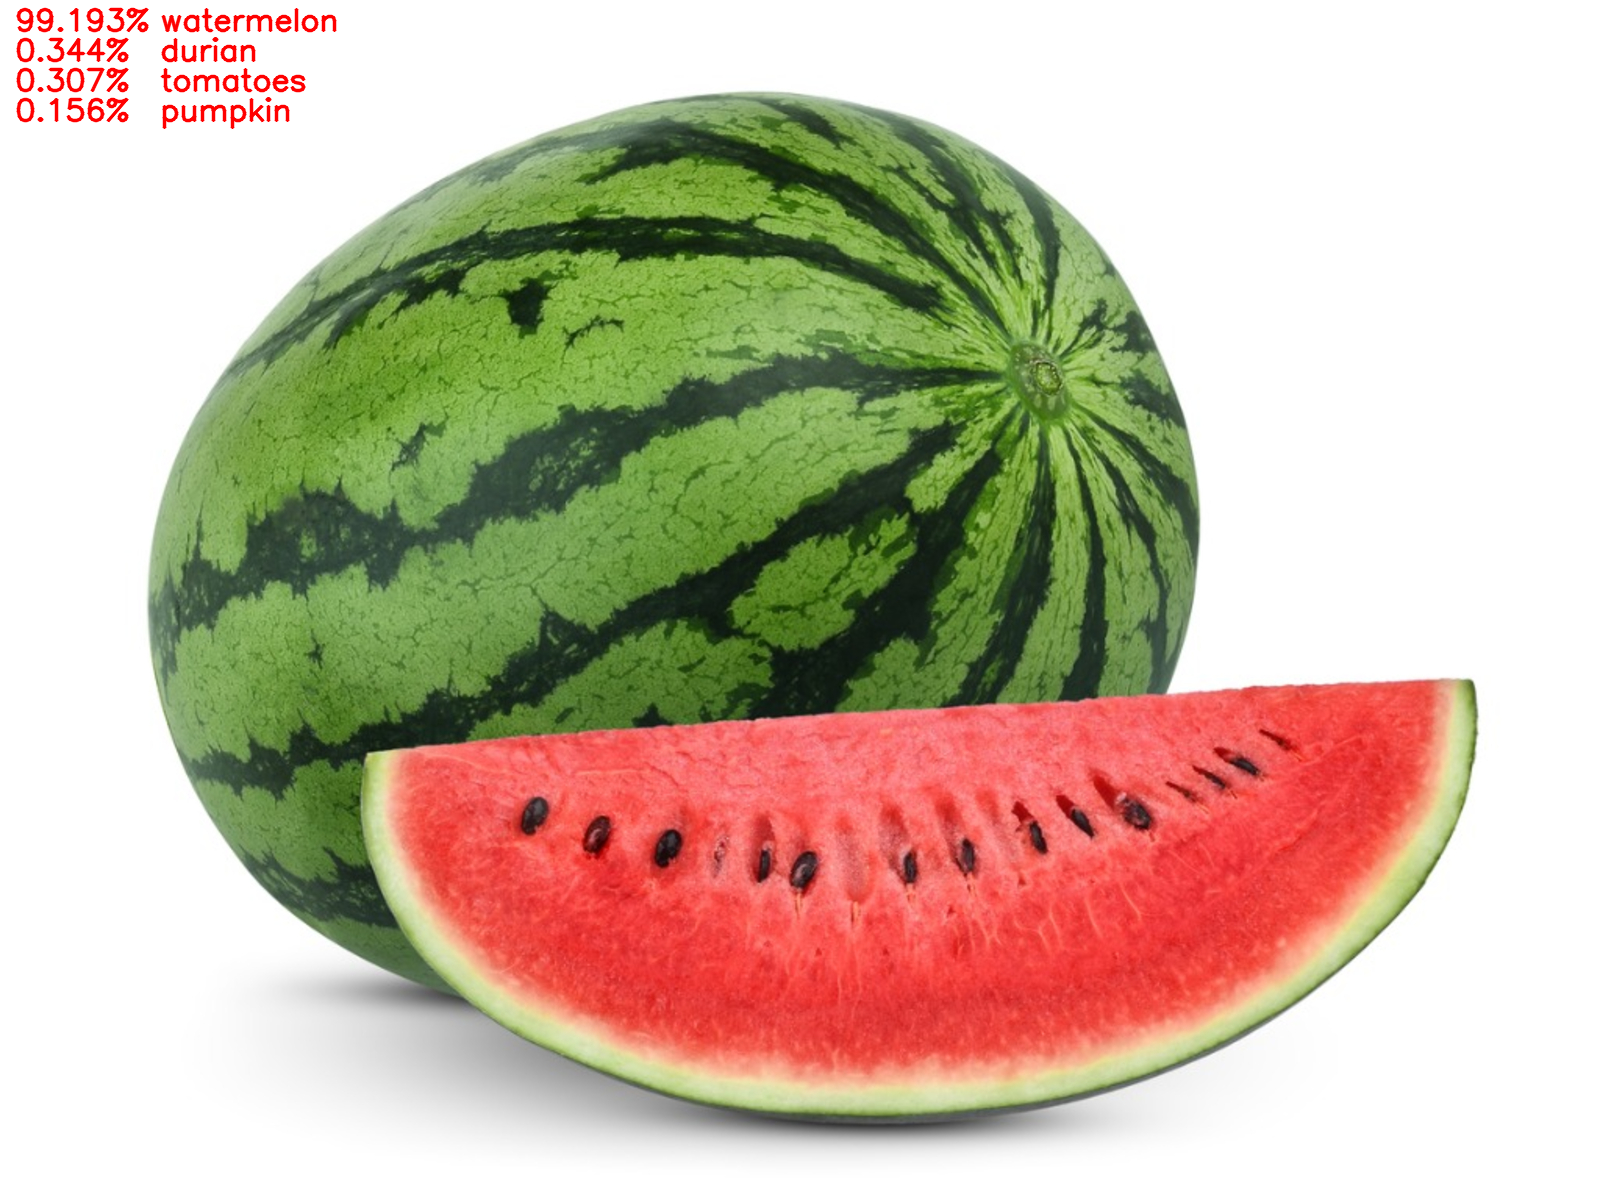

In [57]:
img = cv2.imread('/content/gdrive/MyDrive/assignment 2/watermelonSample.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

pumpkin 0.3381003439426422
durian 0.2760279178619385
tomatoes 0.255075067281723
watermelon 0.13079670071601868


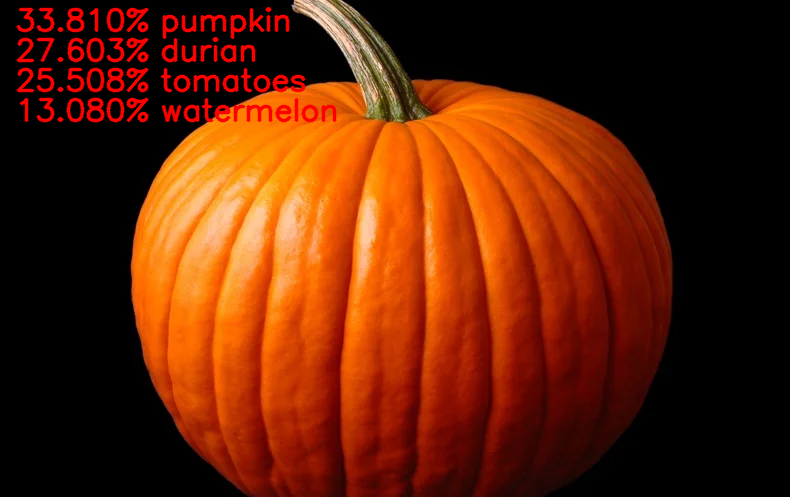

In [58]:
img = cv2.imread('/content/gdrive/MyDrive/assignment 2/pumpkinSample.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

tomatoes 0.9850246906280518
watermelon 0.01180754229426384
durian 0.003094632411375642
pumpkin 7.324661419261247e-05


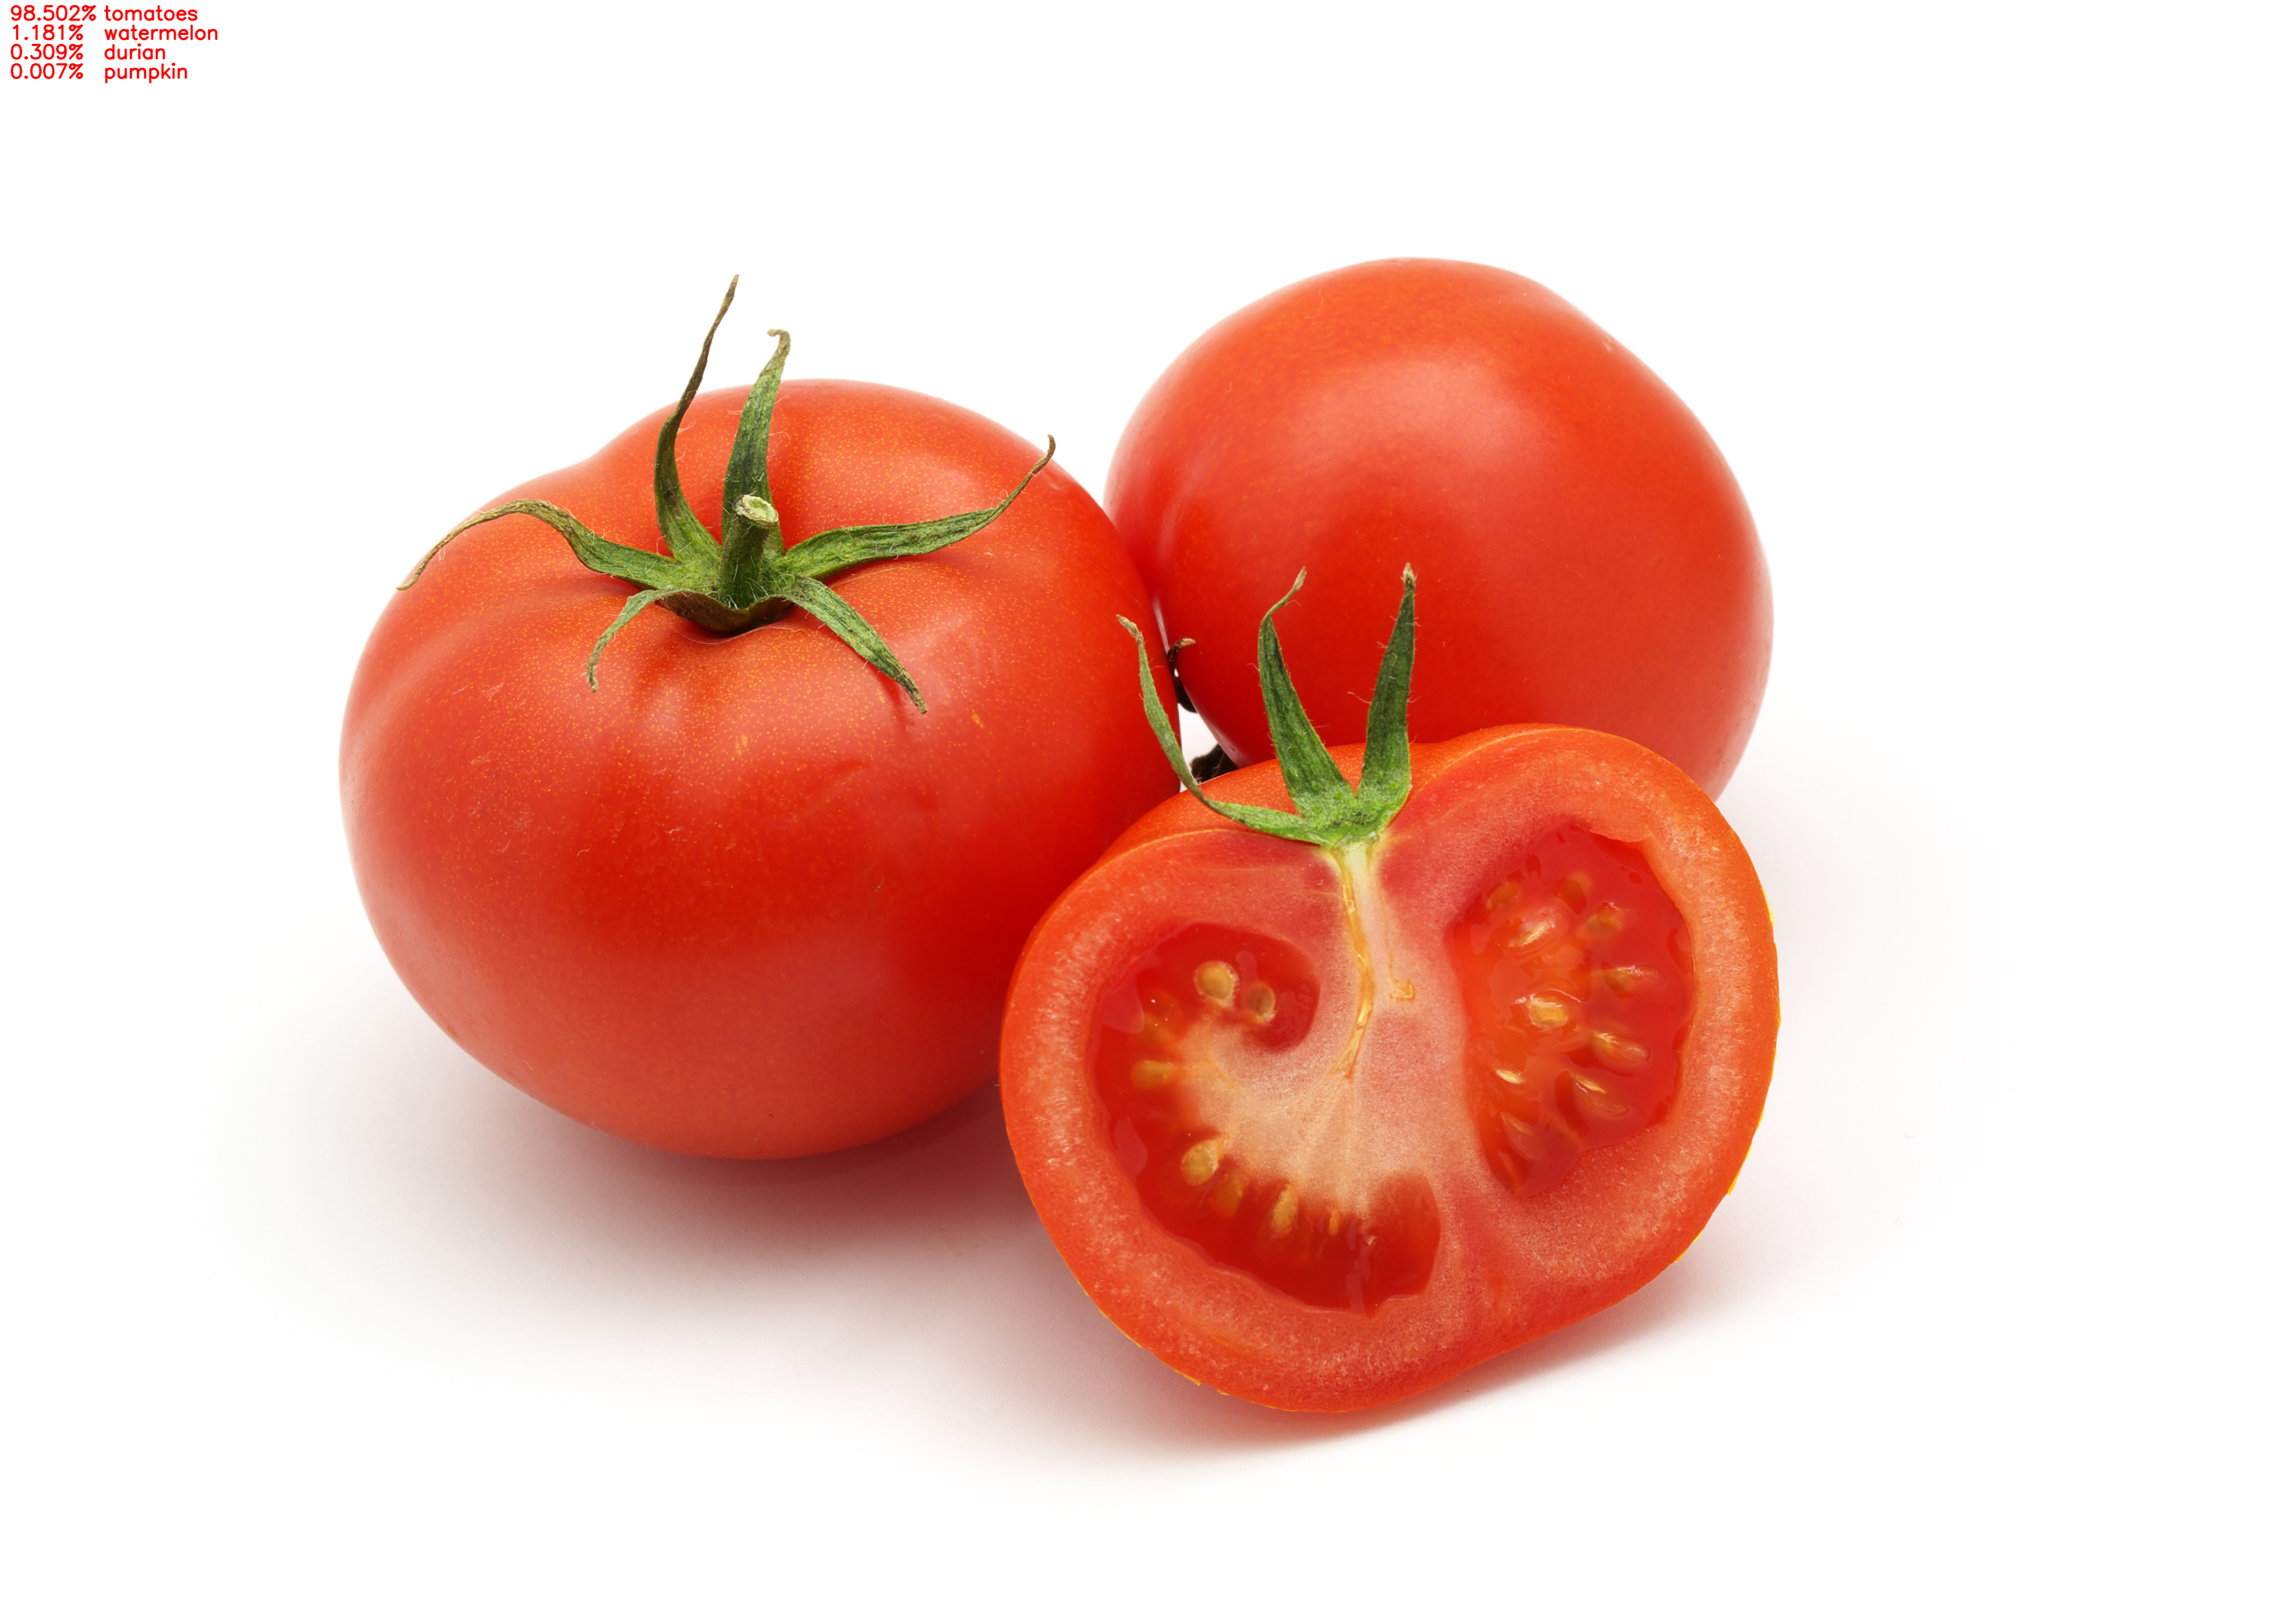

In [62]:
img = cv2.imread('/content/gdrive/MyDrive/assignment 2/tomatoSample.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()